## Computer vision

## Detailed Task Description

In this part you are going to work with [FOOD-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), which contains images of various types of food - 101 classes in total.
The dataset contains the "images" folder with images for each food class, and a "meta" folder with annotations divided into train and test subsets. Annotations are provided in two formats JSON and TXT. You can use any of them. In both cases, the annotation file contains a list of image paths for each food class.

In this part of the task you should perform all the model training on train data and evaluate your models on test data.
Use **[accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** metric for scoring.

### 1. Data analysis


* 1.1 Download the [FOOD-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), visualize several examples from different classes and calculate basic statistics (example number, class distribution, etc.).

**Note:** If you have limited computional resources, you can use only a subset of the original dataset which contains 10 or 50 classes. *There will be no punishement for this*. You can choose any classes you like from the original 101. If you decide to use fewer classes, please write this clearly in your solution and provide a reason for choosing this option.

* 1.2 Split the data from train into `current_train` and `current_val` (`val_size = 10%`). Do not forget to fix `random_state` for reproducibility.

### 2. ResNet Fine-tuning
* 2.1 Take pre-trained [ResNet](https://pytorch.org/vision/main/models/resnet.html) from torchvision (you may take either `ResNet34` or `ResNet50` pre-trained on ImageNet).
* 2.2 Fine-tune pre-trained ResNet on `current_train` created in 1.2. Do not forget about validation on `current_val` created in 1.2 in process of training.
* 2.3 Evaluate your fine-tuned model (use accuracy metric and data from test part for the evaluation), analyze the results and make conclusions.

**Note:** If you decide to use only a subset of the food classes for model training, then you also only need to use the same classes from the test set for evaluation.

### 3. Vit Fine-tuning
In this part you are going to fine-tune [ViT](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library.
* 3.1 Study the [tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb#scrollTo=X9DDujL0q1ac) on fine-tuning Vit model from transformers library.

**Note:** this part is not graded. However, you may find the material from the tutorial useful  for the successful completion of the task.
* 3.2 Take [Vit](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library and initialize it with the [weights pre-trained on ImageNet](https://huggingface.co/google/vit-base-patch16-224).
* 3.3 Similarly to point 2, fine-tune this model on `current_train` created in 1.2. Do not forget about validation on `current_val` created in 1.2 in process of training.
* 3.4 Evaluate your fine-tuned model (use accuracy metric and data from test part for the evaluation), analyze the results and make conclusions.

**Note** If you decide to use only a subset of the food classes for model training, then you also only need to use the same classes from the test set for evaluation.

### 4. Summary & results analysis

* 4.1 Compare the results of the tested models. First, compare them between each other (ResNet vs ViT), then with other models on [leaderboard](https://paperswithcode.com/sota/image-classification-on-food-101-1).

* 4.2 Propose, how you may improve the model score (write at least three ideas).

## 1. Data analysis

### 1.1 Download the FOOD-101 dataset, visualize several examples

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn
import time
import random
from PIL import Image
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler

Transformation settings are in accordance with the [documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50)

In [2]:
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
transform_test = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

Path to save dataset FOOD101 and to obtain data from

In [4]:
# Directory for COLAB session
DATA_DIR =  '/content/data_Food101'

Train dataset

In [5]:
trainset = torchvision.datasets.Food101(root=DATA_DIR, split='train', download=True, transform=transform_train)

100%|██████████| 4996278331/4996278331 [03:23<00:00, 24590627.27it/s]


Extracting /content/data_Food101/food-101.tar.gz to /content/data_Food101


Test dataset

In [6]:
testset = torchvision.datasets.Food101(root=DATA_DIR, split='test', download=True, transform=transform_test)

Info about data

In [7]:
data_img = DATA_DIR + '/food-101/images'
category = "ice_cream"
categories = trainset.classes
directory = os.path.join(data_img, category)
images = glob.glob(f"{directory}/*")
print(f"There are {len(categories)} categories of food {len(images)} images each.")
print(f"Thus, downloaded dataset consists of {len(categories) * len(images)} unique images, where:")
print(' - train dataset consists of {:} images;'.format(len(trainset)))
print(' - test  dataset consists of {:} images.'.format(len(testset)))
print('-'*28)
print("Food categories:")
print(*categories[:5], sep=', ', end=f'...{len(categories) - len(categories[:5])} omitted\n')

There are 101 categories of food 1000 images each.
Thus, downloaded dataset consists of 101000 unique images, where:
 - train dataset consists of 75750 images;
 - test  dataset consists of 25250 images.
----------------------------
Food categories:
apple_pie, baby_back_ribs, baklava, beef_carpaccio, beef_tartare...96 omitted


Let us doublecheck that we downloaded and transformed datasets properly.

In [8]:
print('Train data:\n', trainset)
print('Test data:\n', testset)

Train data:
 Dataset Food101
    Number of datapoints: 75750
    Root location: /content/data_Food101
    split=train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
 Dataset Food101
    Number of datapoints: 25250
    Root location: /content/data_Food101
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


To maintain repeatability we will use `seed_everything` function recommended [here](https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964)

In [9]:
def seed_everything(seed: int):
  '''
  This function is used to maintain repeatability
  '''
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

### Visualizing
Visualizing technique is taken from the [tutorial](https://www.kaggle.com/code/hari31416/food101-eda-and-preprocessing) and adapted for our task.

In [10]:
def plot_random_image(category, axis=False, ax=None):
    directory = os.path.join(data_img, category)
    images = glob.glob(f"{directory}/*")
    random_int = np.random.randint(0, len(images)-1)
    random_image = images[random_int]
    img = plt.imread(random_image)
    ax.imshow(img)
    ax.set_title(category)
    ax.axis(axis)

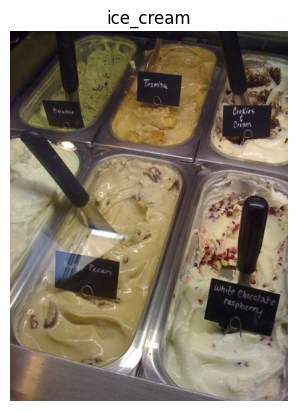

In [ ]:
plot_random_image(category, ax = plt.gca())

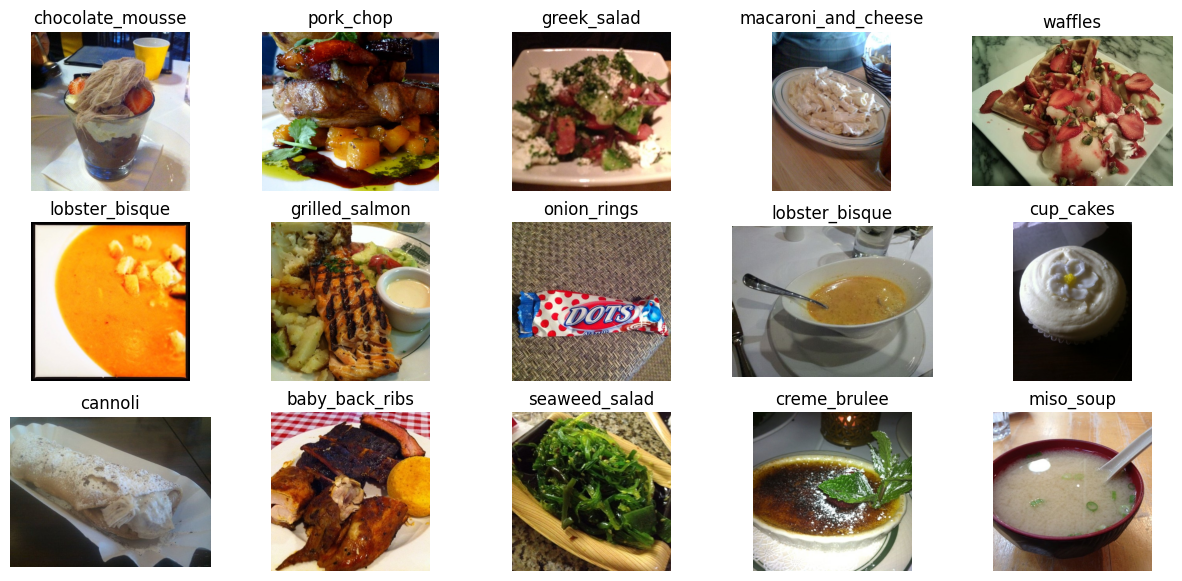

In [ ]:
row = 3
col = 5
fig, axes = plt.subplots(row, col, figsize = (15, 7))
axes = axes.flatten()
for _, ax in enumerate(axes):
    random_cat = np.random.choice(categories)
    plot_random_image(random_cat, ax=ax)
fig.show()

### 1.2 Split the data from train

In [11]:
from torch.utils.data import random_split

seed_everything(42)

# Create a 90-10 train-validation split from trainset

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size

# Divide the dataset by randomly selecting samples.
current_train, current_val = random_split(trainset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

68,175 training samples
7,575 validation samples


In the arcticle *Transfer Learning and ResNet: In search of a perfect batch size* [(link)](https://nikita.melkozerov.dev/posts/2021/01/transfer-learning-and-resnet-in-search-of-a-perfect-batch-size/) was shown that `batch_size = 32` gave the lowest error after 10 epochs of training `ResNet50`  among the following batches: 128, 64, 32, 16, 8, 4. But taking into account that we are obliged to use the same dataset for ResNet50 and ViT, we have to set `batch_size = 16` to avoid `Out of Memory error` for fixed number of epochs.

In [12]:
batch_size = 16

We will create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [13]:
from torch.utils.data import DataLoader

seed_everything(42)

# Create the DataLoaders for our training, validation and test sets.

train_dataloader = DataLoader(
            current_train,  # The training samples.
            batch_size = batch_size, # Trains with this batch size.
            shuffle=True, num_workers=2
        )

validation_dataloader = DataLoader(
            current_val, # The validation samples.
            batch_size = batch_size, # Evaluate with this batch size.
            shuffle=True, num_workers=2
        )

test_dataloader = DataLoader(
            testset, # The test samples.
            batch_size=batch_size,
            shuffle=True, num_workers=2
        )

Let us create a dictionary `dataloaders`, this will make usage of  `train_dataloader`, `validation_dataloader` and `test_dataloader` more convenient.

In [14]:
dataloaders = {
    'train': train_dataloader,
    'val': validation_dataloader,
    'test': test_dataloader
}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x78101180dab0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x78101180d9c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x78101180ee00>}

In the following dictionary we will collect sizes of the correspondent datasets.

In [15]:
dataset_sizes = {
    'train': len(dataloaders['train'].dataset),
    'val': len(dataloaders['val'].dataset),
    'test': len(dataloaders['test'].dataset)
}
dataset_sizes

{'train': 68175, 'val': 7575, 'test': 25250}

## 2. ResNet Fine-tuning

This chapter is based on *TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL* [(link)](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

### Training the model

Check the potential ability to use GPU for model training.

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In `train_model` function we will
implement the following:
-  Scheduling the learning rate
-  Saving the best model

Function `format_time` is used for monitoring the time of the training progress.

In [17]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Function `train_model` is used for training the model.

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4, ViT=False):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)
            step = 0
            t0 = time.time()
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # Progress update every 100 batches.
                    if step % 100 == 0 and not step == 0:

                        # Calculate elapsed time in minutes.
                        elapsed = format_time(time.time() - t0)

                            # Report progress
                        print('Phase {:}:  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'\
                                  .format(phase, step, len(dataloaders[phase]), elapsed))
                    step += 1

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        # when ViT model is trained only logits tensor from outputs is needed
                        if ViT:
                          outputs = outputs.logits
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Train and evaluate

Load a pretrained model and reset final fully connected layer.


In [ ]:
model_ResNet50 = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
# "Freeze" all the layers
for param in model_ResNet50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ResNet50.fc.in_features
model_ResNet50.fc = torch.nn.Linear(num_ftrs, len(categories))

model_ResNet50 = model_ResNet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ResNet50 = torch.optim.SGD(model_ResNet50.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ResNet50, step_size=2, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.5MB/s]


Start training

In [ ]:
model_ResNet50 = train_model(model_ResNet50, criterion,
                       optimizer_ResNet50, exp_lr_scheduler,
                       num_epochs=7)

Epoch 1/7
----------
Phase train:  Batch   100  of  4,261.    Elapsed: 0:00:19.
Phase train:  Batch   200  of  4,261.    Elapsed: 0:00:33.
Phase train:  Batch   300  of  4,261.    Elapsed: 0:00:45.
Phase train:  Batch   400  of  4,261.    Elapsed: 0:00:57.
Phase train:  Batch   500  of  4,261.    Elapsed: 0:01:10.
Phase train:  Batch   600  of  4,261.    Elapsed: 0:01:23.
Phase train:  Batch   700  of  4,261.    Elapsed: 0:01:35.
Phase train:  Batch   800  of  4,261.    Elapsed: 0:01:46.
Phase train:  Batch   900  of  4,261.    Elapsed: 0:01:59.
Phase train:  Batch 1,000  of  4,261.    Elapsed: 0:02:11.
Phase train:  Batch 1,100  of  4,261.    Elapsed: 0:02:24.
Phase train:  Batch 1,200  of  4,261.    Elapsed: 0:02:39.
Phase train:  Batch 1,300  of  4,261.    Elapsed: 0:02:52.
Phase train:  Batch 1,400  of  4,261.    Elapsed: 0:03:09.
Phase train:  Batch 1,500  of  4,261.    Elapsed: 0:03:24.
Phase train:  Batch 1,600  of  4,261.    Elapsed: 0:03:38.
Phase train:  Batch 1,700  of  4,26

### Visualizing the model predictions

Generic function to display predictions for a few images.

In [19]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 10))
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if title is not None:
      print('Titles of the pictures row by row (from left to right):')
      for i in range(0, batch_size, batch_size // 4):
        print(*title[i:i+batch_size // 4], sep=', ')

In [20]:
def visualize_model(model, num_images=6, ViT=False):
    was_training = model.training
    model.to(device)
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(7, 7))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if ViT:
              outputs = outputs.logits
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis(False)
                if categories[preds[j]] == categories[labels[j]]:
                  ax.set_title(f'PASSED\ntrue: {categories[labels[j]]},\npredicted: {categories[preds[j]]}')
                else:
                  ax.set_title(f'FAILED\ntrue: {categories[labels[j]]},\npredicted: {categories[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Inference on custom images

Use the trained model to make predictions on custom images and visualize
the true and predicted class labels along with the images.

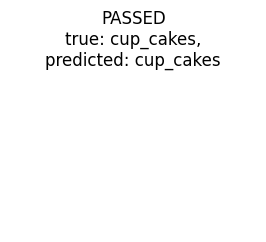

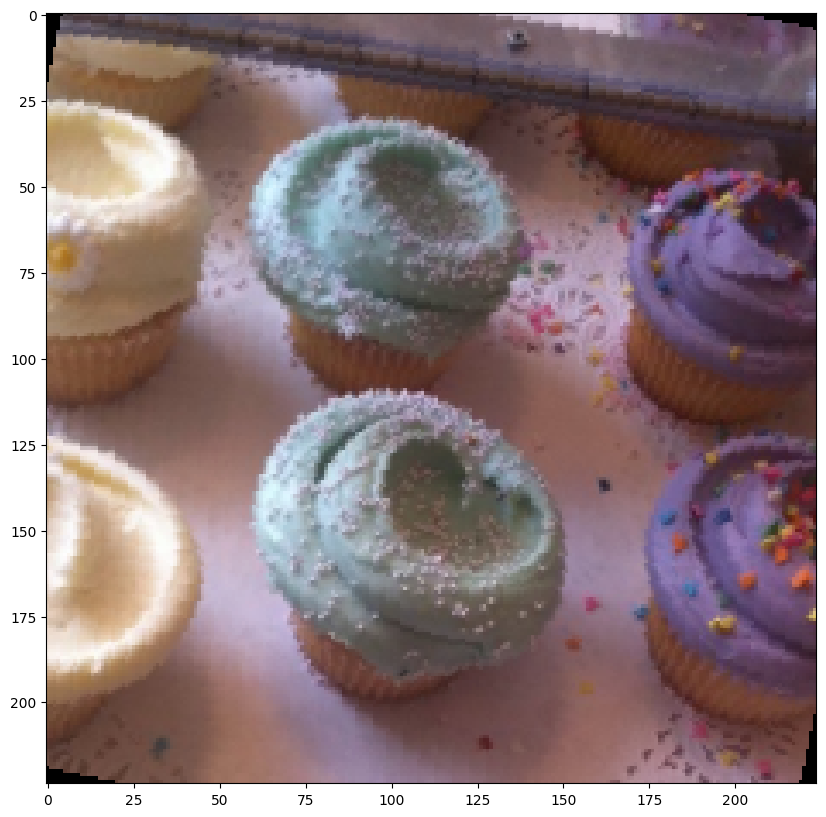

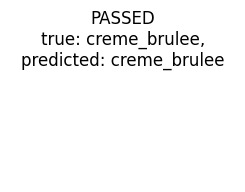

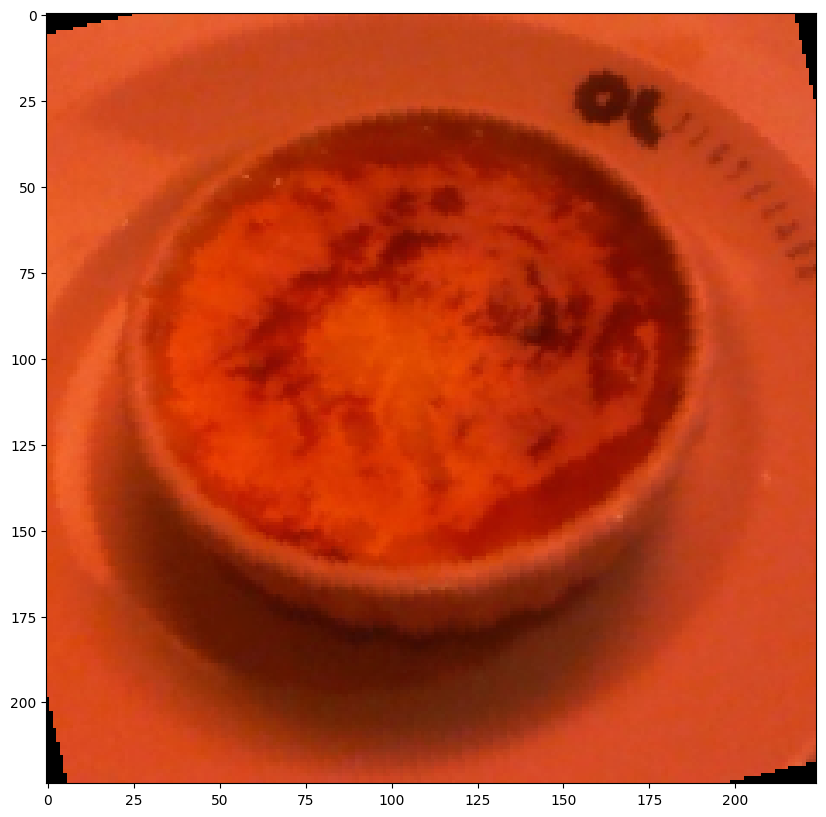

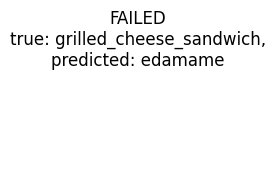

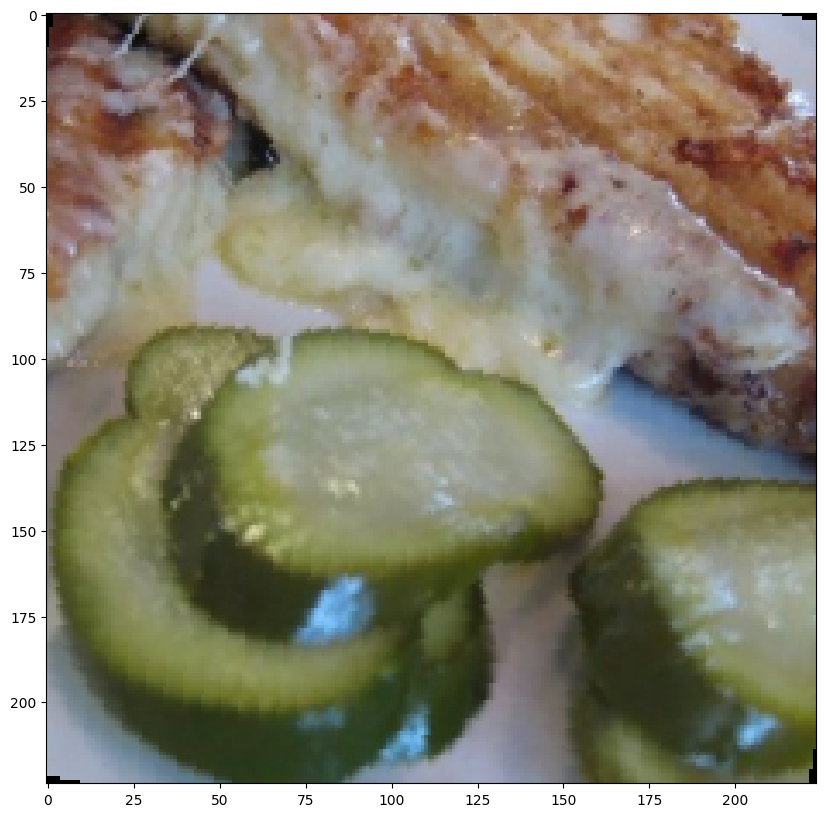

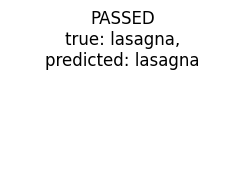

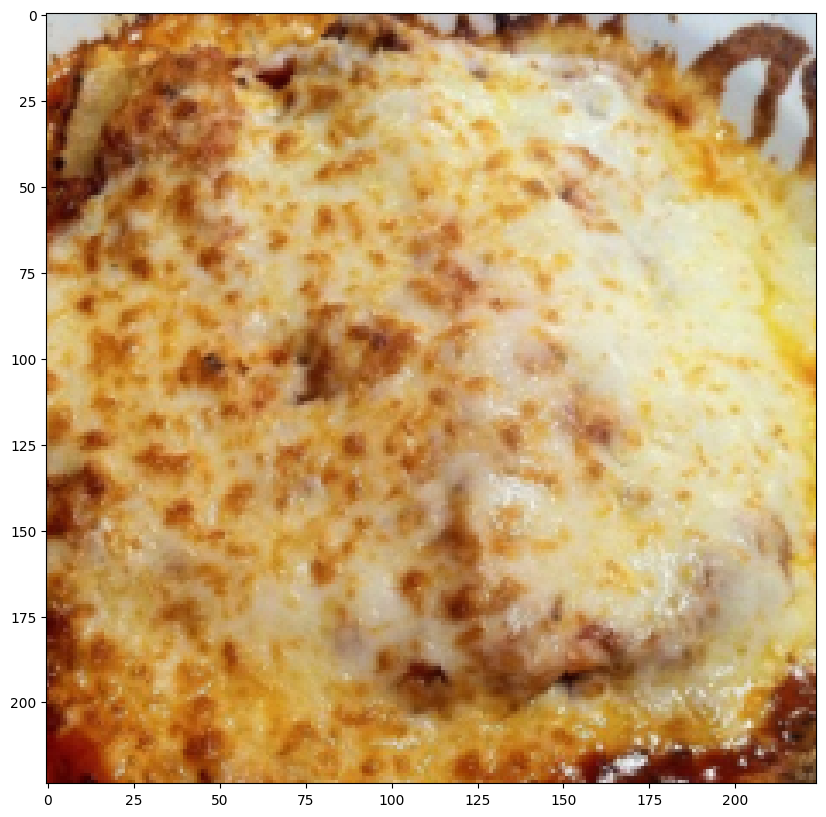

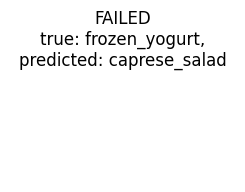

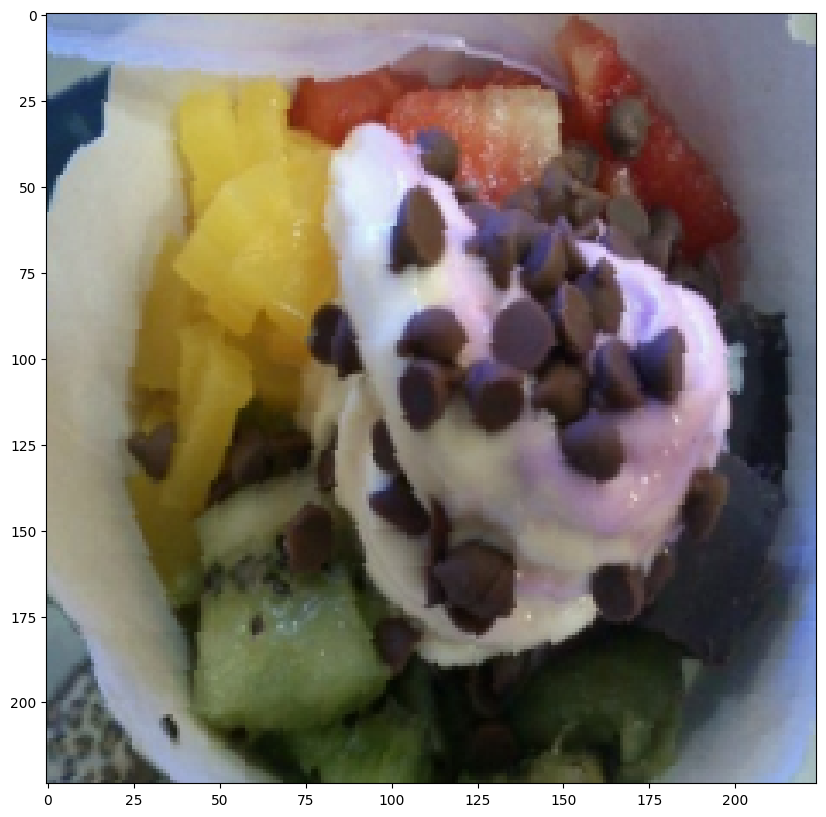

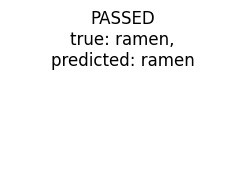

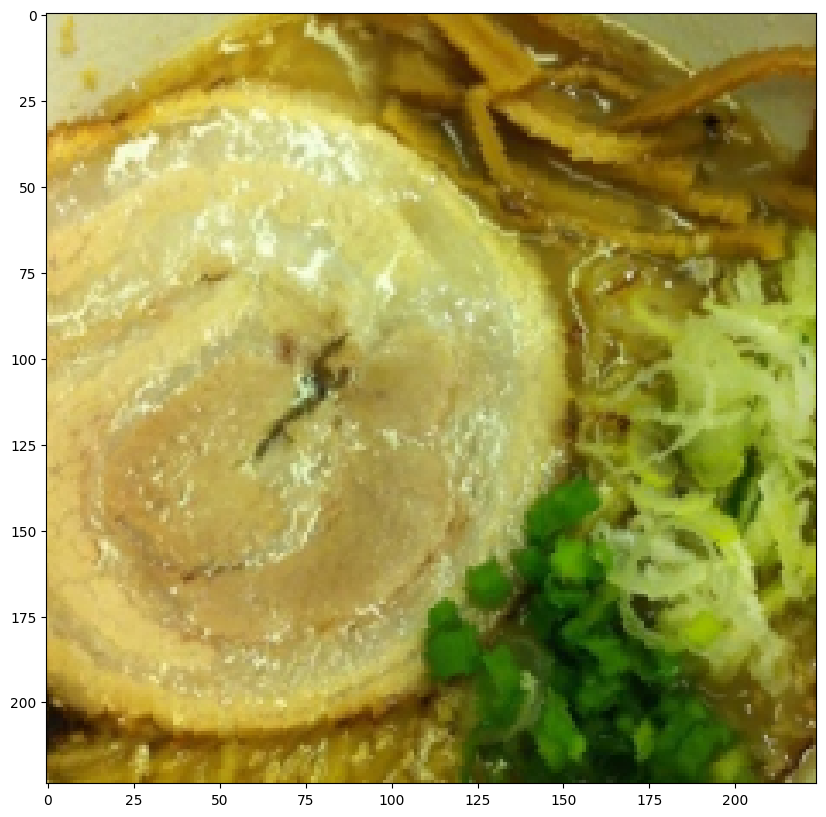

In [ ]:
visualize_model(model_ResNet50)

### Performance on test

We will implement a function for testing, in which we calculate the accuracy of our model (i.e. percentage of correct predictions).

Note: `test` function is taken from *Programming Assignment Task of WEEK 4* of the Deep Learning course.

In [21]:
def test(model, dataloader, ViT=False):

    model.to(device)
    model.eval()

    with torch.no_grad():
        correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if ViT:
          outputs = outputs.logits
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    accuracy = correct/len(dataloader.dataset)

    return accuracy

In [ ]:
accuracy = test(model_ResNet50, dataloaders['test'])
print(f"\nResNet50 test accuracy: {100*round(accuracy, 2)}%")

100%|██████████| 1579/1579 [02:48<00:00,  9.37it/s]


ResNet50 test accuracy: 51.0%


## 3. ViT Fine-tuning

This chapter is based on *Fine-tuning for Image Classification with 🤗 Transformers* [(link)](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb#scrollTo=X9DDujL0q1ac)

We will use datasets obtained in 1.2.

In [22]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00


Load a pretrained model directly from HuggingFace library.


In [43]:
from transformers import AutoModelForImageClassification

model_ViT = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                        num_labels = 101, # The number of output labels=101 for FOOD101 dataset
                                                        ignore_mismatched_sizes=True,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, we have printed out the names and dimensions of the weights for:

- the embedding layer;
- the first of the twelve transformers;
- the output layer.

In [44]:
# Get all of the model's parameters as a list of tuples.
params = list(model_ViT.named_parameters())

print('The ViT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[4:16]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The ViT model has 200 different named parameters.

==== Embedding Layer ====

vit.embeddings.cls_token                                 (1, 1, 768)
vit.embeddings.position_embeddings                      (1, 197, 768)
vit.embeddings.patch_embeddings.projection.weight       (768, 3, 16, 16)
vit.embeddings.patch_embeddings.projection.bias               (768,)

==== First Transformer ====

vit.encoder.layer.0.attention.attention.query.weight      (768, 768)
vit.encoder.layer.0.attention.attention.query.bias            (768,)
vit.encoder.layer.0.attention.attention.key.weight        (768, 768)
vit.encoder.layer.0.attention.attention.key.bias              (768,)
vit.encoder.layer.0.attention.attention.value.weight      (768, 768)
vit.encoder.layer.0.attention.attention.value.bias            (768,)
vit.encoder.layer.0.attention.output.dense.weight         (768, 768)
vit.encoder.layer.0.attention.output.dense.bias               (768,)
vit.encoder.layer.0.intermediate.dense.weight            (3

In [45]:
model_ViT

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

"Freeze" all the layers of ViT model and reset final fully connected layer, namely `classifier`.

In [46]:
# "Freeze" all the layers
for param in model_ViT.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ViT.classifier.in_features
model_ViT.classifier = torch.nn.Linear(num_ftrs, len(categories))

model_ViT = model_ViT.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized 
optimizer_ViT = torch.optim.AdamW(model_ViT.classifier.parameters())

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ViT, step_size=3, gamma=0.1)

Start training.

In [47]:
model_ViT = train_model(model_ViT, criterion,
                    optimizer_ViT, exp_lr_scheduler,
                    num_epochs=4, ViT=True)

Epoch 1/4
----------
Phase train:  Batch   100  of  4,261.    Elapsed: 0:00:20.
Phase train:  Batch   200  of  4,261.    Elapsed: 0:00:42.
Phase train:  Batch   300  of  4,261.    Elapsed: 0:01:02.
Phase train:  Batch   400  of  4,261.    Elapsed: 0:01:22.
Phase train:  Batch   500  of  4,261.    Elapsed: 0:01:42.
Phase train:  Batch   600  of  4,261.    Elapsed: 0:02:02.
Phase train:  Batch   700  of  4,261.    Elapsed: 0:02:22.
Phase train:  Batch   800  of  4,261.    Elapsed: 0:02:42.
Phase train:  Batch   900  of  4,261.    Elapsed: 0:03:02.
Phase train:  Batch 1,000  of  4,261.    Elapsed: 0:03:22.
Phase train:  Batch 1,100  of  4,261.    Elapsed: 0:03:43.
Phase train:  Batch 1,200  of  4,261.    Elapsed: 0:04:03.
Phase train:  Batch 1,300  of  4,261.    Elapsed: 0:04:23.
Phase train:  Batch 1,400  of  4,261.    Elapsed: 0:04:43.
Phase train:  Batch 1,500  of  4,261.    Elapsed: 0:05:03.
Phase train:  Batch 1,600  of  4,261.    Elapsed: 0:05:23.
Phase train:  Batch 1,700  of  4,26

### Inference on custom images

Use the trained model to make predictions on custom images and visualize
the true and predicted class labels along with the images.

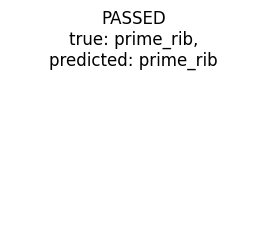

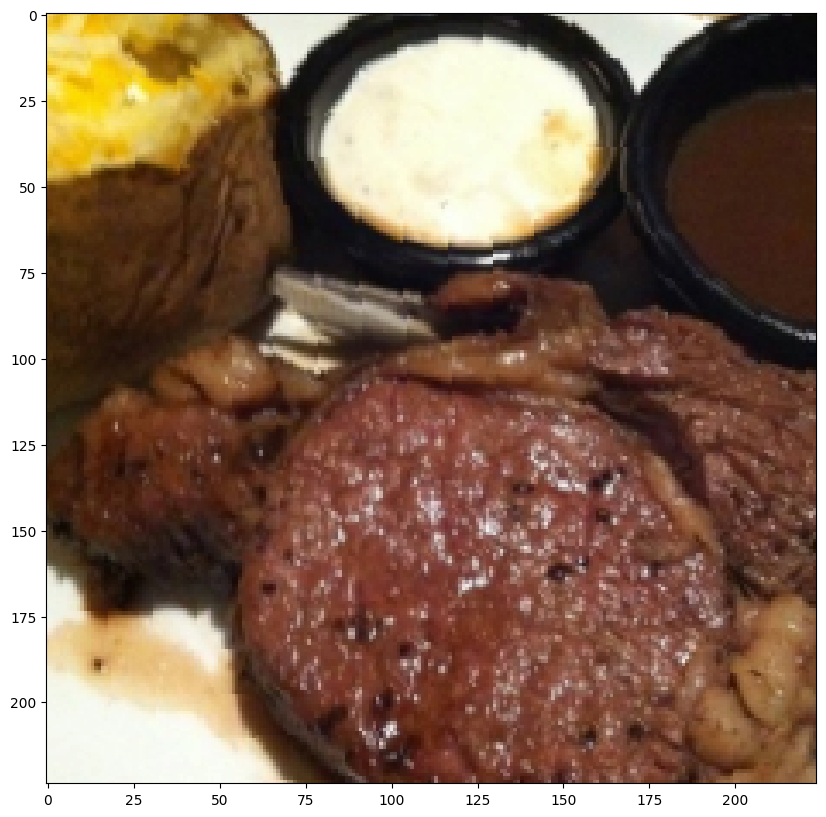

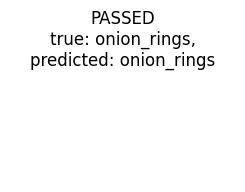

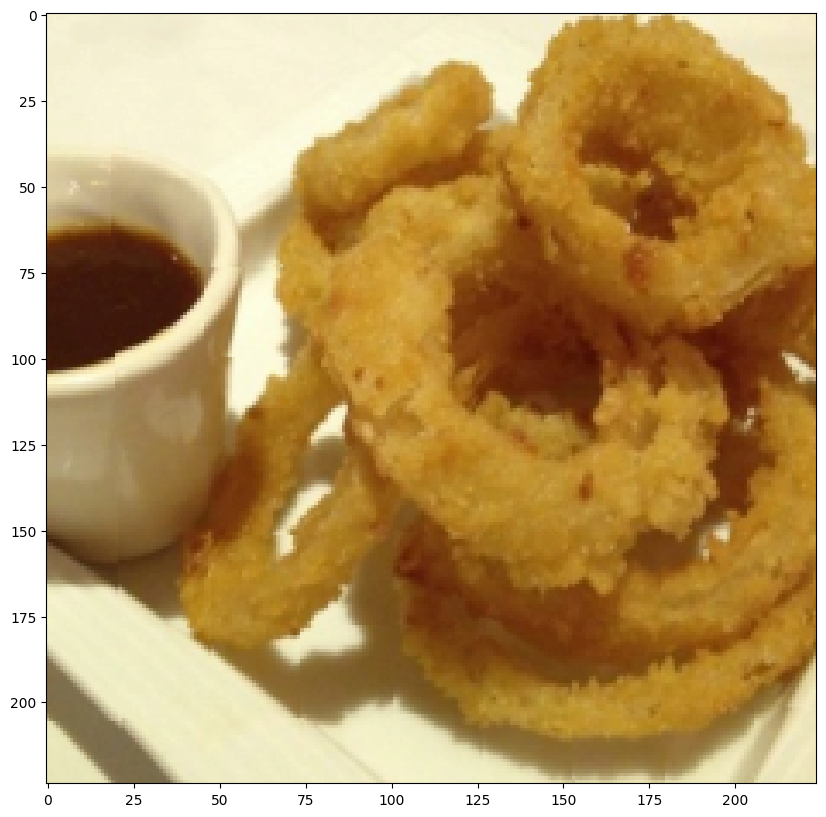

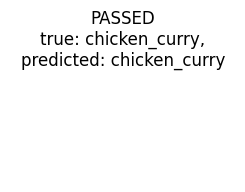

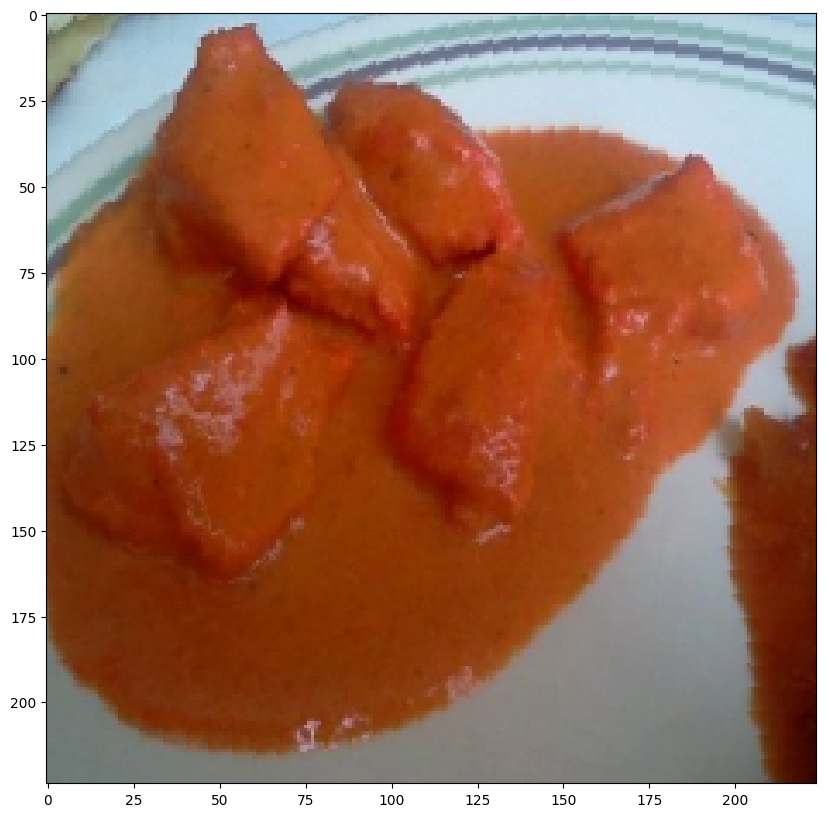

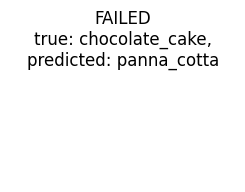

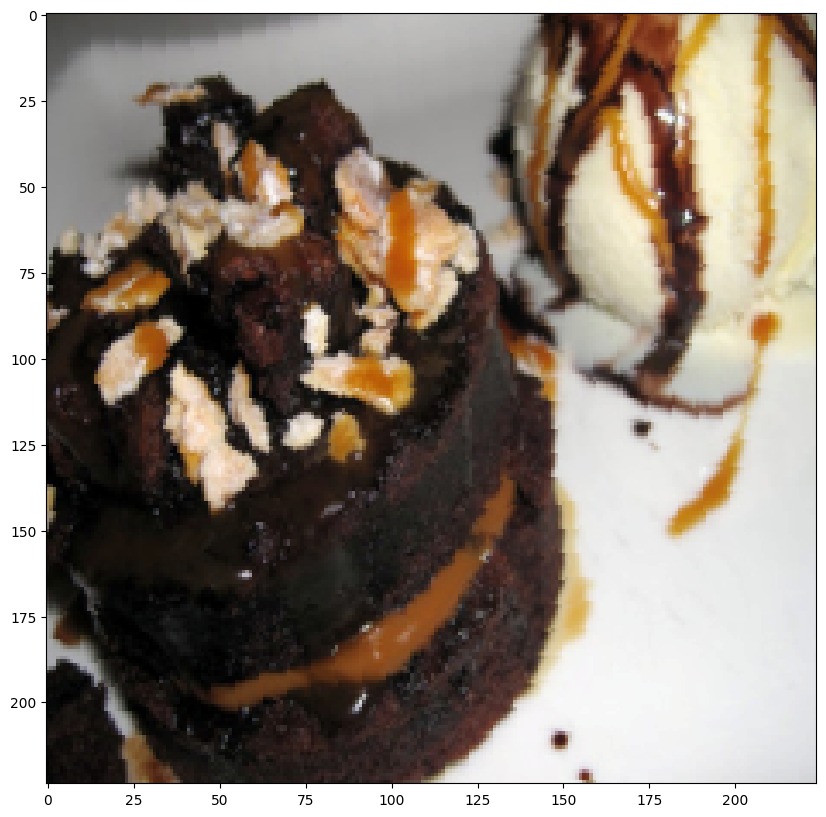

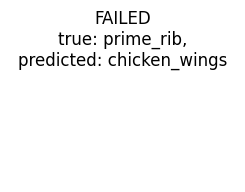

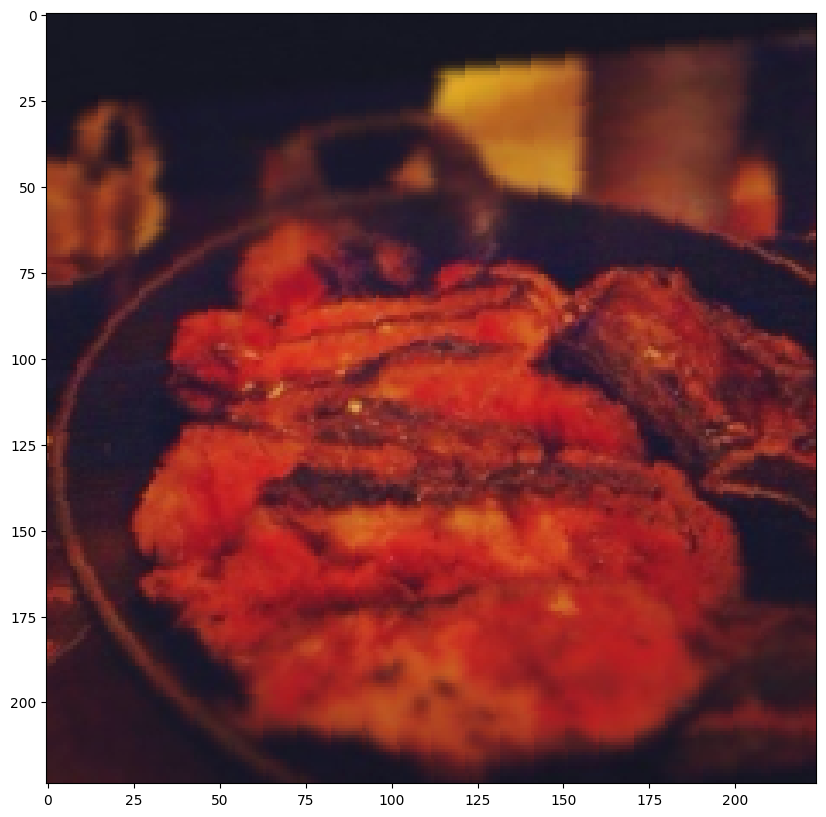

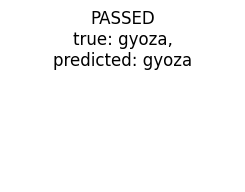

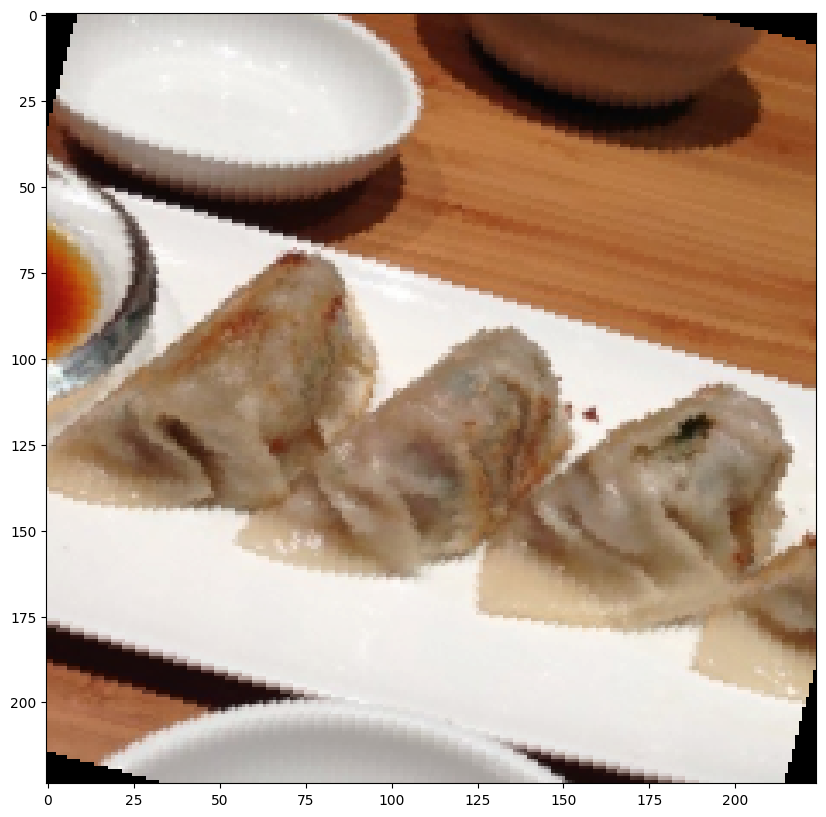

In [48]:
visualize_model(model_ViT, ViT=True)

### Performance on test

In [49]:
accuracy = test(model_ViT, dataloaders['test'], ViT=True)
print(f"\nViT test accuracy: {100*round(accuracy, 2)}%")

100%|██████████| 1579/1579 [05:21<00:00,  4.92it/s]


ViT test accuracy: 81.0%


## 4. Summary & results analysis

### 4.1. Compare the results

Let us populate the following `table 1` with all the data we obtained.

Table 1

|id|Model|Accuracy, %|
|--|:--|:--:|
|1|ResNet50|51.0|
|2|ViT|81.0|

**ResNet50** - convolutional neural network: 7 epochs of training, training complete in 64m 39s.

**ViT** - Visual Transformer: 4 epochs of training, training complete in 63m 38s.

Time of training of both networks are quite close, but ViT model demonstrated significantly greater accuracy value, so Transformer is more effective than ResNet50 with convolutional layers. 

Let us populate the following `table 2` with top-3 models on [leaderboard](https://paperswithcode.com/sota/image-classification-on-food-101-1)

Table 2

|Rank|Model|Accuracy, %|
|:--:|:--|:--:|
|1|**Bamboo** (ViTB/16)|92.9|
|2|**SEER** (RegNet10B - linear eval)|90.3|
|3|**TWIST** (ResNet-50)|89.3|

Comparing tables 1 and 2, we may come to the conclusion that our ViT neural network demonstrated quite good accuracy since only the classifier layer was trained on the FOOD101 dataset and all other layers were frozen. Of course, the result is expectedly not even close to the top-3 on leaderboard. 

### 4.2. Way of possible improvement of the model score

Due to lack of computational resources I had to use GPU provided free of charge by Google Colab. Practically GPU was available only for an hour and a half during the day. Therefore, I was limited with number of epochs to set for the trainig purposes.
I believe there are at least 3 ways to improve the quality metric of the model:
- use another optimizer for more precise calculations of minimum of Loss function;
- since we used Transfer Learning technique we could not frozen all the layers but the last one. I mean we may choose the number of layers to freeze by trials and errors method (for this, unlimited computational resources are needed);
- extend training dataset even more, probably $\frac{\text{training set cardinality}}{\text{number of categories}} = \frac{68175}{101} = 675$ pictures per category simply not enough to train the model properly.